In [1]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

import cassiopeia as cas
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from ete3 import Tree, TreeStyle, faces
from typing import Tuple
import scipy

In [2]:
#TLS1_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk'
TLS1_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/neighbor/AM-DNA-097_neighbor_newick_noMutationlessEdges_Labeled.nwk'

meta_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/neighbor/AM-DNA-097_metadata.txt'
character_matrix_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/neighbor/AM-DNA-097_character_matrix.txt'
priors_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/neighbor/AM-DNA-097_priors.pickle'
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
clusterFile = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_clusterTable.txt'
allele_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/allele_table_filtered.txt'

In [3]:
colorDictFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(colorDictFile,'rb') as fp:
    colorDict = pickle.load(fp)

In [4]:
allele_table = pd.read_csv(allele_loc, sep = '\t')

In [5]:
tree = Tree(TLS1_loc, format=1)
tree_meta = pd.read_csv(meta_loc, sep='\t')
character_matrix = pd.read_csv(character_matrix_loc, sep='\t', index_col = 0)

with open(priors_loc, 'rb') as f:
    priors = pickle.load(f)
        
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)

# Create a cassiopeia Tree        
test_tree = cas.data.CassiopeiaTree(character_matrix = character_matrix, priors = priors, tree = tree)
    
missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T
test_tree.cell_meta = tree_meta
test_tree.character_meta = character_meta

test_tree.cell_meta['cluster'] = test_tree.cell_meta['cell_state'].str[2:-2]
test_tree.cell_meta.set_index("cellBC",inplace = True)

In [6]:
data = pd.read_csv(clusterFile,sep='\t')
data.rename(columns={"Unnamed: 0": "cellBC"},inplace=True)
data.set_index("cellBC",inplace=True)

numClusters = data.shape[1]

In [7]:
with open(colorDictFile,'rb') as fp:
    colorDict = pickle.load(fp)

t = Tree(TLS1_loc,format=1)

data["totalCells"]=data.sum(axis=1)
colNames = data.columns[0:(data.shape[1]-1)].values

mCells = data["totalCells"].max()

filling in multiindex table:   0%|          | 0/14524 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.23it/s]


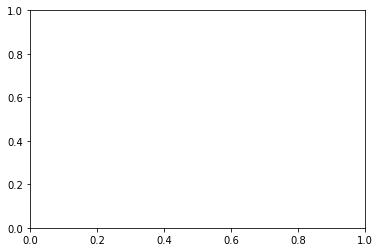

In [12]:
fig, ax = plt.subplots()
cas.pl.plot_matplotlib(test_tree, allele_table = allele_table, orient = 'right', figsize = (10, 40))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/AM-DNA-097_Indel_Heatmap.pdf', dpi = 900)
#plt.show()
plt.close()

In [29]:
def mylayout(node):
    #if node.is_leaf():
    #    node.img_style["size"]=0
    #else:
    cvals = data.loc[node.name,colNames].values
    totalCells = float(cvals.sum())
    if totalCells==0:
        print(node.name)
    pcts = (cvals/totalCells)*100
    idx = np.nonzero(pcts)
    apct = [pcts[i] for i in idx[0]]
    acol = [colorDict[colNames[i]] for i in idx[0]]
    # scale size to total cells
    pSize = mCells/10.
    #pSize = np.log2(totalCells+(mCells/1000.))*0.5
    pSize = np.log2(totalCells) #+(mCells/100.)) # works well
    pSize = 3 
    #pSize = np.log2(totalCells+0.1)
    if pSize<1:
        pSize=1

    if not node.is_root(): 
    # PieChartFace(percents,width,height,colors,line_color) 
        C = faces.PieChartFace(apct,colors=acol,width=pSize,height=pSize)
        C.border.width = None
        C.opacity = 0.8
        #faces.add_face_to_node(C,node,0,position="branch-bottom") # opt1: branch bottom
        faces.add_face_to_node(C,node,position="float",column=0) # opt2: float

    node.img_style["size"]=0

In [22]:
def mylayout(node):
    #if node.is_leaf():
    #    node.img_style["size"]=0
    #else:
    cvals = data.loc[node.name,colNames].values
    totalCells = float(cvals.sum())
    if totalCells==0:
        print(node.name)
    pcts = (cvals/totalCells)*100
    idx = np.nonzero(pcts)
    apct = [pcts[i] for i in idx[0]]
    acol = [newColorDict[colNames[i]] for i in idx[0]]
    # scale size to total cells
    pSize = mCells/10.
    #pSize = np.log2(totalCells+(mCells/1000.))*0.5
    Size = np.log2(totalCells) #+(mCells/100.)) # works well
    #pSize = 10 
    #pSize = np.log2(totalCells+0.1)
    if pSize<1:
        pSize=1

    #if not node.is_root(): 
    # PieChartFace(percents,width,height,colors,line_color) 
        #C = faces.PieChartFace(apct,colors=acol,width=pSize,height=pSize)
        #C.border.width = None
        #C.opacity = 0.8
        #faces.add_face_to_node(C,node,0,position="branch-bottom") # opt1: branch bottom
        #faces.add_face_to_node(C,node,position="float",column=0) # opt2: float
        #C2 = faces.TextFace(node.name,fsize=5)
        #faces.add_face_to_node(C2,node,position="branch-right",column=0)

    if node.is_leaf():
        #C = faces.PieChartFace(apct,colors=acol,width=40,height=5)
        C = faces.BarChartFace(apct,colors=acol,width=80,height=5)
        C.labels = None
        C.border.width = None
        C.opacity = 0.8
        faces.add_face_to_node(C,node,0,position="branch-right") # opt1: branch bottom
        #C2 = faces.TextFace(node.name,fsize=5)
        #faces.add_face_to_node(C2,node,position="branch-right",column=0)

In [9]:
colorDict

{'pPSM': 'SlateBlue',
 'Somite': 'MediumOrchid',
 'aPSM': 'DarkSlateBlue',
 'NeuralTube1': 'ForestGreen',
 'NeuralTube2': 'DarkGreen',
 'Somite-1': 'Purple',
 'Unknown': 'Gray',
 'PCGLC': 'Red',
 'Somite0': 'DarkViolet',
 'NMPs': 'Turquoise',
 'Endoderm': 'Yellow',
 'SomiteSclero': 'Pink',
 'Endothelial': 'MediumBlue',
 'SomiteDermo': 'Magenta'}

In [9]:
newColorDict = {'pPSM': 'Gray',
                'Somite': 'Purple',
                'aPSM': 'Gray',
                'NeuralTube1': 'ForestGreen',
                'NeuralTube2': 'ForestGreen',
                'Somite-1': 'Purple',
                'Unknown': 'Gray',
                'PCGLC': 'Red',
                'Somite0': 'Purple',
                'NMPs': 'Turquoise',
                'Endoderm': 'Yellow',
                'SomiteSclero': 'Purple',
                'Endothelial': 'MediumBlue',
                'SomiteDermo': 'Purple'}

/tmp/ipykernel_161849/178102593.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation=90)


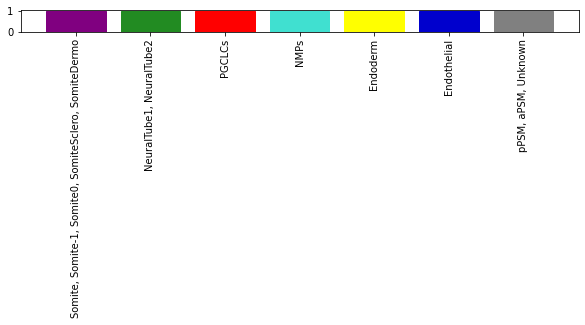

In [8]:
boxes = [1, 1, 1, 1, 1, 1, 1]

c = ['Purple', 'ForestGreen', 'Red', 'Turquoise', 'Yellow', 'MediumBlue', 'Gray']

names = ['Somite, Somite-1, Somite0, SomiteSclero, SomiteDermo', 'NeuralTube1, NeuralTube2', 'PGCLCs', 'NMPs', 'Endoderm', 'Endothelial', 'pPSM, aPSM, Unknown']
fig, ax = plt.subplots(figsize = (10, 3))

bars = ax.bar(names, height = boxes)
count = 0
for color in c:
    bars[count].set_color(color)
    count += 1
ax.set_xticklabels(names, rotation=90)
plt.subplots_adjust(top = 1, bottom=0.9)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/colors.pdf', dpi = 300)
plt.show()
plt.close()

In [23]:
ts = TreeStyle()
ts.layout_fn = mylayout
ts.show_leaf_name = False
ts.show_branch_length = False
ts.allow_face_overlap = True
#ts.min_leaf_separation = 0
ts.mode = "c"
ts.show_scale = False

In [24]:
outfile = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/plots/AM-DNA-097_Ete_Circular_Plot_Colors.pdf'
outSizeLen = 10
outSizeHeight = 10

In [25]:
t.render(file_name=outfile,w=outSizeLen,h=outSizeHeight,units="in",tree_style=ts)

{'nodes': [[363.87536258782285,
   456.8870379957239,
   364.4403103140916,
   457.4519857219926,
   0,
   None],
  [561.0694970152673,
   478.9952210191321,
   561.7086465929755,
   479.6343705968402,
   1,
   None],
  [593.9612033319077,
   449.738392061894,
   594.4844192081197,
   450.26160793810595,
   2,
   None],
  [593.9422670746196,
   451.8263610019317,
   594.4730163801711,
   452.3571103074832,
   3,
   None],
  [622.9973792127444,
   450.771600058153,
   623.5237105097954,
   451.2979313552039,
   4,
   None],
  [652.0407587446591,
   450.4279054365935,
   652.5657571536137,
   450.95290384554824,
   5,
   None],
  [652.0332427197169,
   451.4621636448332,
   652.5609034567648,
   451.9898243818811,
   6,
   None],
  [681.0764451792664,
   451.3156277333378,
   681.6032200065358,
   451.84240256060707,
   7,
   None],
  [681.068824173189,
   452.1042271775703,
   681.5973692836556,
   452.63277228803685,
   8,
   None],
  [622.9823370110616,
   452.0999647428947,
   623.51

In [14]:
test_palette = []
for i in colorDict.keys():
    test_palette.append(colorDict[i])
    
test_tree.cell_meta['cluster'] = [i[2:-2] for i in test_tree.cell_meta['cell_state']]

values = test_tree.cell_meta['cluster']

colors = test_palette[: len(values.unique())]
colormap = dict(zip(np.unique(values), colors))

final_palette = []
for i in colormap.keys():
    final_palette.append(colorDict[i])

print('------------------{}----------------------')    
cas.pl.upload_and_export_itol(test_tree, 'AM-DNA-097_neighbor_cell_states_Timepoint', api_key = 'jtMaYpxAc94ImqU7xJjubQ',
                      project_name = 'AM-DNA-097', export_filepath='/Genomics/chanlab/blaw/TLS/sandbox/AM-DNA-097_greedy_cell_states_timepoint.pdf', 
                      meta_data = ['cluster'])

------------------{}----------------------
iTOL output: SUCCESS: 12811211774156531687787932

Tree Web Page URL: http://itol.embl.de/external.cgi?tree=12811211774156531687787932&restore_saved=1
Warnings: []
